In [ ]:
!pip install pycm livelossplot
%pylab inline

# London Hack Pytorch Tutorial Session 3
## From Convolutions to Conv Nets

In the following exercise we will cover the following concepts:
- Traditional Convolution based Computer Vision 
- Implement a traditional kernel-based methods visualized on a given image
- Visualize various convolutional layers on a given image
- Torch Convolutional layers 
- Implementation of LeNet
- Simple ConvNet Excercise on MNIST - all training methods given, only change networks
- Training with Data Augmentation
- Transfer Learning for FashionMNIST

#### A few imports before we get started

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


### Mounting the google drive for later storage

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


### Computer Vision - Convolutions as Feature Detectors

In the following exercise we'll do some classical computer vision before moving to convolutional networks.
A classical convolution operator is the so-called [Sobel-Filter](https://en.wikipedia.org/wiki/Sobel_operator)

#### Task 1:
Implement the Sobel Filter G_x from the provided website as a simple nn.conv2d operation.
Hint: First instantiate a ```nn.Conv2d``` object with a single 3x3 kernel, padding=1, taking in a single image channel and outputting one channel.  
Then modify the weight matrix to reflect the sobel filter.

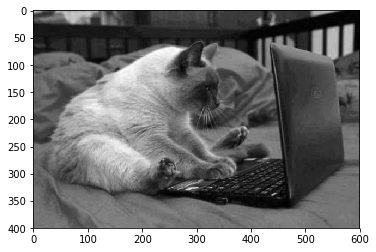

In [16]:
from PIL import Image
import requests
from io import BytesIO

url = "https://cataas.com/cat"
response = requests.get(url)
img = np.array(Image.open(BytesIO(response.content)).convert('L')).astype(float)
plt.imshow(img, cmap="gray")

### Task 1: Implement the Sobel Filter $G_x$

torch.Size([1, 1, 3, 3])
tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])


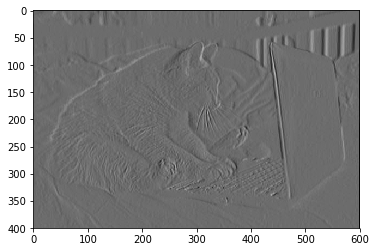

In [22]:
sobel = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
print(sobel.weight.data.size())
filter = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).float().view(1, 1, 3, 3)
print(filter)
sobel.weight.data = filter
x = torch.from_numpy(img).view(1, 1, img.shape[0], img.shape[1]).float()
filtered_cat = sobel(x)
plt.imshow(filtered_cat.detach().numpy()[0, 0], cmap="gray")

### Some useful Convolutional Layers

- Convolutions and Transposed Convolutions: Convolutional layers are parameterized by their kernel-weights and biases and are often used to reduce the spatial dimensionality.
- Transposed Convolutions: Similar to convolutions, but these can increase the spatial dimensionality. [Blog on Problems with Tranposed Convolutions](https://distill.pub/2016/deconv-checkerboard/)
- Upsampling Layers: Bilinear and Nearest Neighbor Upsampling
- Pooling Layers: As discussed in the lecture notes - summarize spatial information - AveragePooling, MaxPooling, etc.
- Dropout: Also exists in two (and more) dimensions: Can be use to regularise training of deep networks
- Batchnormalization: Shift and center the distribution of the weights to a centered Gaussian distribution by keeping a running average of mini-batch properties.  
Has been shown to help learning in very deep convolutional neural networks. [But it is not really well understood why this is the case.](https://arxiv.org/abs/1805.11604)

The pytorch documentation is extremely well organised and I highly recommend you use it to your own advantage.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


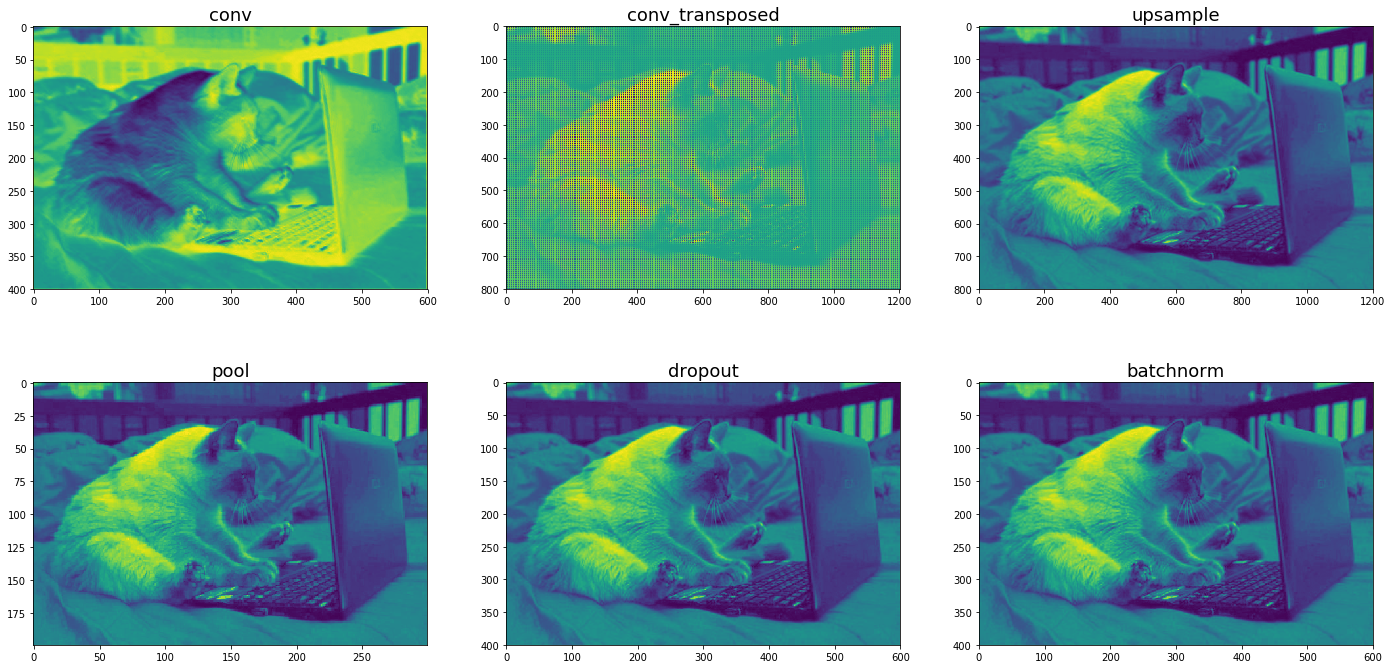

In [30]:
convolution = nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=1)
transposed_convolution = nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2)
upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
dropout = nn.Dropout2d(0.5)
batchnorm = nn.BatchNorm2d(1)

fig, axarr = plt.subplots(2, 3, figsize=(24, 12))
for ax, op, name in zip(axarr.flatten(), [convolution, transposed_convolution, upsampling, pool, dropout, batchnorm], ["conv", "conv_transposed", "upsample", "pool", "dropout", "batchnorm"]):
  filtered = op(x)
  ax.imshow(filtered[0, 0].detach().numpy())
  ax.set_title(name, fontsize=18)
plt.show()

### Task 2: A simple Convolutional Network - LeNet-5
![](https://www.researchgate.net/profile/Vladimir_Golovko3/publication/313808170/figure/fig3/AS:552880910618630@1508828489678/Architecture-of-LeNet-5.png)

Let's now use our knowledge (and Pytorch documentation) Yann LeCun's LeNet-5 shown above.  
You only have to implement the network itself, we provide you with the rest of the training code.  
This is nearly identical to what you have already done in the previous session.  
Assume that you will apply this to the MNIST dataset (28x28 grayscale images).  
Here the network is shown to have input's of size 32x32, but we'll use zero-padding to achieve the same output size of the first convolutional layer.  
All convolutional layers with trainable parameters should have a kernel-size=5.  
In LeCun's [original paper](http://yann.lecun.com/exdb/lenet/) he did not use any padding, what is the size of the convolutional kernels?  
Also, ReLU's did not exist at the time, but we'll use them here.

In [ ]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)
  
x = torch.randn((1, 1, 28, 28))
model = LeNet5()
y = model(x)
print(y)

### The MNIST Dataset - Hello World of Deep-Learning - Now with ConvNets!

In [40]:
mnist_train = MNIST("./", download=True, train=True)
mnist_test = MNIST("./", download=True, train=False)

0it [00:00, ?it/s]

9920512it [00:01, 8830263.97it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 134859.23it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2203652.93it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50935.54it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


### Instantiate and create a ```StratifiedShuffleSplit``` using sklearn.
1. Create a ```sklearn.model_selection.StratifiedShuffleSplit``` object with 1-split and a test-size of 10%.
2. Get the training and validation indices from the shuffel-split 

In [41]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.train_data, mnist_train.train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


### Splitting and normalize the data
The original mnist data is given in gray-scale values between 0 and 255.
You will need to write a normalisation method that takes in a ```torch.Tensor``` and performs normalisation.
The mean of MNIST is 0.1307 and it's standard deviation is 0.3081 (after division by 255).

Finally, torch likes all categorical data to be in a ```.long()``` format.
Therefore


In [0]:
def apply_normalization(X):
  X /= 255.
  X -= 0.1307
  X /= 0.3081
  return X

In [43]:
X_train, y_train = apply_normalization(mnist_train.train_data[indices[0]].float()), mnist_train.train_labels[indices[0]]
X_val, y_val = apply_normalization(mnist_train.train_data[indices[1]].float()), mnist_train.train_labels[indices[1]]
X_test, y_test =  apply_normalization(mnist_test.test_data.float()), mnist_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Instantiate a ```torch.utils.data.TensorDataset``` for training, validation and test data

In [0]:
mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

Let's visualise an example of the images and check whether the data is normalised properly (compute .mean() and .std() on the training set.)

tensor(9.8159e-05) tensor(1.0003)


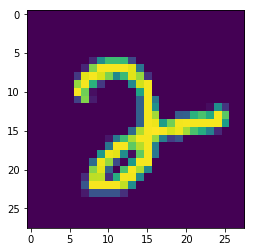

In [45]:
plt.imshow(X_train[0])
print(X_train.mean(), X_train.std())

### Provided Train, Validation and Evaluate Functions


In [0]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 28, 28))
        #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

 ### Set the hyperparameters of your model
- Seed: 42
- learning rate: 1e-2
- Optimizer: SGD
- momentum: 0.9
- Number of Epochs: 30
- Batchsize: 64
- Test Batch Size (no effect on training apart from time): 1000
- Shuffle the training set every epoch: Yes

In [0]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

### Instantiate our model, optimizer and loss function
Set the random number generator seed using ```set_seed``` to make everything reproducible.
As a criterion use a sensible loss for the multi-class classification problem.

### Perform the training of the network and validation
Here we provide you with a method to visualize both training and validation loss while training your networks.

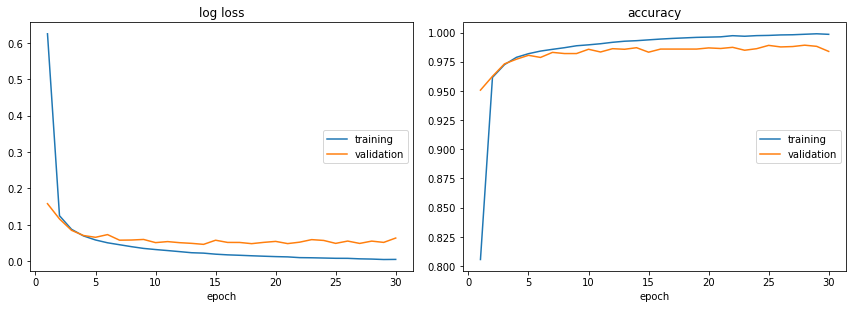

log loss:
training   (min:    0.005, max:    0.625, cur:    0.005)
validation (min:    0.046, max:    0.158, cur:    0.064)

accuracy:
training   (min:    0.806, max:    0.999, cur:    0.998)
validation (min:    0.951, max:    0.989, cur:    0.984)


True

In [56]:
def train_model(momentum):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
  test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model

model = train_model(0.5)

### Implement an evaluate method
This method performs the same as validate but doesn't report losses, but simply returns all predictions on a given dataset (training, validation, test-set)

In [0]:
validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
y_pred, y_gt = evaluate(model, validation_loader)

### Plotting a confusion matrix

We can use a confusion matrix to diagnose problems in our models.
We may see for example that our model confuses 9's for 4's quite often.

In [58]:
cm = ConfusionMatrix(actual_vector=y_gt, predict_vector=y_pred) # Create CM From Data
print(cm)

Predict   0         1         2         3         4         5         6         7         8         9         
Actual
0         587       1         0         0         0         0         2         1         1         0         

1         0         673       1         0         0         0         0         0         0         0         

2         0         1         593       0         1         0         0         0         1         0         

3         2         0         3         604       0         2         0         1         1         0         

4         0         0         0         0         582       0         0         1         0         1         

5         0         0         0         1         0         536       3         0         1         1         

6         3         0         0         0         1         0         588       0         0         0         

7         0         5         1         0         3         0         0         617       1       

### Given that you estimated your hyperparameters, train your model on the full dataset and evaluate on the test set

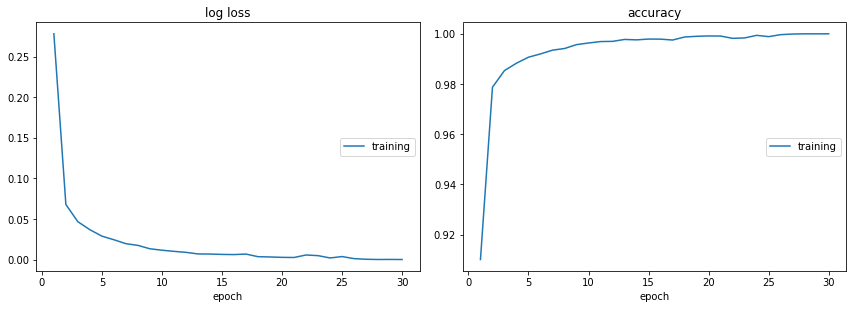

log loss:
training   (min:    0.000, max:    0.278, cur:    0.000)

accuracy:
training   (min:    0.910, max:    1.000, cur:    1.000)
Avg. Test Loss: 0.037  Avg. Test Accuracy: 0.993



In [60]:
mnist_train = MNIST("./", download=True, train=True)

X_train, y_train = apply_normalization(mnist_train.train_data.float()), mnist_train.train_labels
mnist_train = TensorDataset(X_train, y_train)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'LeNet5_mnist_classifier.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

### Custom Datasets and Transforms

Pytorch allows us to simply extend the available Datasets to more custom functionality.
Here we provide an example of such a custom dataset class.
You can see that there are 3 functions we need to implement:
- __init__(*args, **kwargs): this will handle everything prior to actually using the dataset
- __len__(self): returns the length of the dataset i.e. the number of data items
- __getitem__(self, idx): this method takes an index of a specific data item and returns that item.
  - You can do whatever you want in these functions: apply transforms, normalize data, perform another computation etc.
  - Here we also have the functionality to apply a set of [```torchvision.transforms```](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms)

In [0]:
from torch.utils.data import Dataset 

class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(1, 28, 28).float()/255.
        if self.transform:
            sample = self.transform(sample)

        return sample, label

### Transforms

Transforms can be used to perform manipulation of individual data prior to passing the data to our models.
This is useful for:
 - Data-augmentation i.e. creating slightly modified instance of the data we have while preserving their labels.
 - Data Preprocessing: Such as Normalization, Histogram Equalization 
 - Transforming Targets: You may have complex labels that should change together with changes in the preprocessing of the images
 
 Pytorch and especially torchvision provides a [number of transforms](https://pytorch.org/docs/stable/torchvision/index.html) for you to use!
 A nice tutorial on custom dataloaders and transforms can be found [here](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).
 
 The (probably) most state-of-the-art library for image augmentation is [albumentations](https://github.com/albu/albumentations) which has been successfully applied in winning kaggle competitions.

Using Albumentations is a bit more involved but you can find tutorials [here]().

In [0]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage


#Often we will want to apply more transformations at training time than test time, therefore here we have two different ones
train_transform = Compose([
    ToPILImage(),
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=[0.1307], std=[0.3081]), 

])

#In Validation and Test Mode we only want to normalize our images, because they are already tensors
validation_test_transform = Compose([
    Normalize(mean=[0.1307], std=[0.3081])
])

### Excercise 2: Training with data augmentation

- Instantiate a ```CustomImageTensorDataset``` with data from the MNIST dataset
- Provide the training and validation and testing datasets with the right transforms
- Train LeNet-5 with data-augmentation on a validation set, then train on the full training set and report accuracies. Did you improve the model?


### Creating the ```CustomImageTensorDataset```

In [116]:
mnist_train = MNIST("./", download=True, train=True)
X_train, y_train = mnist_train.train_data[indices[0]], mnist_train.train_labels[indices[0]]
X_val, y_val = mnist_train.train_data[indices[1]], mnist_train.train_labels[indices[1]]

custom_mnist_train = CustomImageTensorDataset(X_train, y_train, transform=train_transform)
mnist_validation = CustomImageTensorDataset(X_val, y_val, transform=validation_test_transform)
mnist_test = CustomImageTensorDataset(X_test, y_test, transform=validation_test_transform)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


### Training LeNet5 with data augmentation

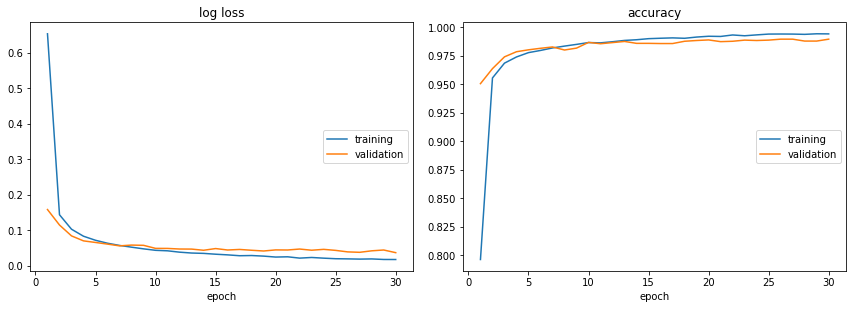

log loss:
training   (min:    0.017, max:    0.653, cur:    0.017)
validation (min:    0.036, max:    0.158, cur:    0.036)

accuracy:
training   (min:    0.796, max:    0.994, cur:    0.994)
validation (min:    0.951, max:    0.990, cur:    0.990)


True

In [117]:
def train_model_augmented(train_dataset, validation_dataset, momentum=0.5):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model

model = train_model_augmented(custom_mnist_train, mnist_validation)

### Training on the full dataset

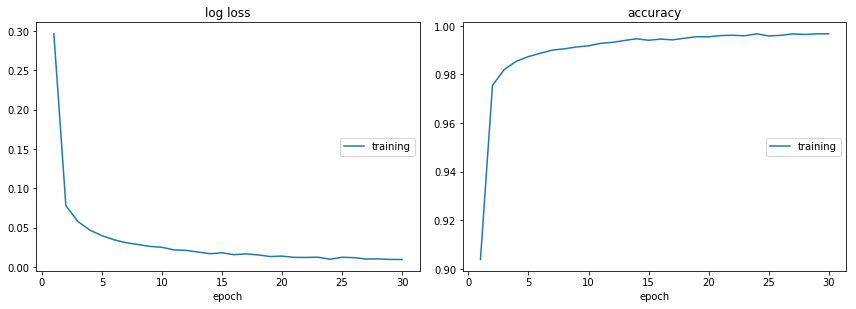

log loss:
training   (min:    0.010, max:    0.296, cur:    0.010)

accuracy:
training   (min:    0.904, max:    0.997, cur:    0.997)
Avg. Test Loss: 0.032  Avg. Test Accuracy: 0.993



In [122]:
mnist_train = MNIST("./", download=True, train=True, transform=Compose([
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=[0.1307], std=[0.3081]), 

]))
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'LeNet5_mnist_classifier_with_augmentation.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

### Transfer Learning

We will now explore one of the arguably most useful practises when dealing with small-datasets and wanting to create a powerful classifier - transfer learning.  
The basic principle behind is to leverage features learned on very large datasets and reuse them to perform tasks on smaller datasets.  
To be able to apply transfer learning effectively, the data distribution of the data that a very powerful model was trained on should follow a similar distribution as the smaller dataset that we are trying to apply transfer learning to.    

For example:  
_We want to create a new classifier for cats and dogs given only a small set of say 100 training images of each category._

Very deep neural networks that have been trained on ImageNet or CIFAR have similar categories in their dataset, say horses and maybe cows and many more categories of natural images.  
The intuition is that since we've already learned a rich set of features on ImageNet, we can simply use a deep network as a feature extractor and only retrain the final layer of the networks to perform well at our task. So let's work our way towards transfer learning.


### Excercise 3: Inspecting the features of pre-trained deep neural networks

Pytorch provides users with a rich set of pre-trained neural network architectures. These have mostly been pre-trained on imagenet.   
[```torchvision.models```](https://pytorch.org/docs/stable/torchvision/models.html) provides us with an interface to these pretrained deep neural networks.

- Load a pretrained AlexNet model from ```torchvision.models```
- Obtain the weight kernels of the first layer and display them (11x11 kernels shown as a matplotlib graph)
- Remembering the earlier excercise on traditional computer vision kernels and edge detection, how could these come in handy when learning on new data?


In [136]:
from torchvision import models

alexnet = models.alexnet(pretrained=True)
print(alexnet.features)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
244418560it [00:09, 25658960.59it/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


torch.Size([64, 3, 11, 11]) tensor(-0.7819) tensor(0.9354)


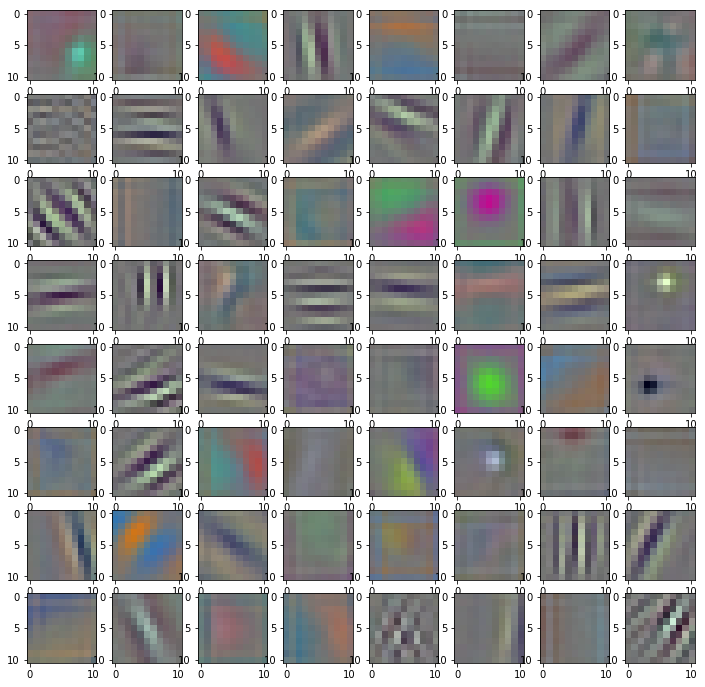

In [142]:
for layer in alexnet.features.children():
  weights = layer.weight.data
  print(weights.size(), weights.min(), weights.max())
  break

min_w, max_w =  weights.min(), weights.max()
weights -= min_w
weights /= (max_w-min_w)

fig, axarr = plt.subplots(8, 8, figsize=(12, 12))
axarr = axarr.flatten()
for ax, kernel in zip(axarr, weights.numpy()):
  ax.imshow(np.swapaxes(kernel, 0, 2))

### Transfer learning from MNIST to FashionMNIST

In the previous excercise we've investigated what the features of a very deep pre-trained network look like and learned about transfer learning.
We've also already created a powerful classifier for MNIST, let's see if we can perform equally well on FashionMNIST with a limited dataset.
Perform the following tasks:
1. Load the FashionMNIST dataset
2. Visualize a few examples of the dataset
3. Create a Training Set and Validation Set by using ```StratifiedShuffleSplit``` and use only 10% of the training data for training.
  - You will also need to normalize the FashionMNIST data to the same range as you did for the MNIST.
4. Train a newly initialized LeNet5 on the 100% of the Training Data as a baseline
5. Train a newly initialized LeNet5 on 10% of the training data
6. Use the LeNet5 pretrained on MNIST (load the weights from the previous excercise) and perform the following:
  - Replace the last layer of the LeNet with a new linear Layer
  - Set the learning rates for all other layers to 0, except the final classifier
  - Train on 10% of the data, validate against the remaining 90%, then predict on the full test set.
  - How does your transfer learned model compare against learning from scratch?
  - What happens when you train a full model on the 10% of data?
  
You can set different learning rates for different layers like so:
```
optim.SGD([
{‘params’: model.base.parameters()},
{‘params’: model.classifier.parameters(), ‘lr’: 1e-3}
], lr=1e-2, momentum=0.9)```

In [144]:
from torchvision.datasets import FashionMNIST

  0%|          | 98304/26421880 [00:00<00:28, 934380.44it/s]

26427392it [00:00, 85026871.64it/s]                             


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 299306.72it/s]                           
0it [00:00, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:00, 23927240.12it/s]                         
8192it [00:00, 160228.59it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## 1. Training a newly initialized LeNet5 on FashionMNIST

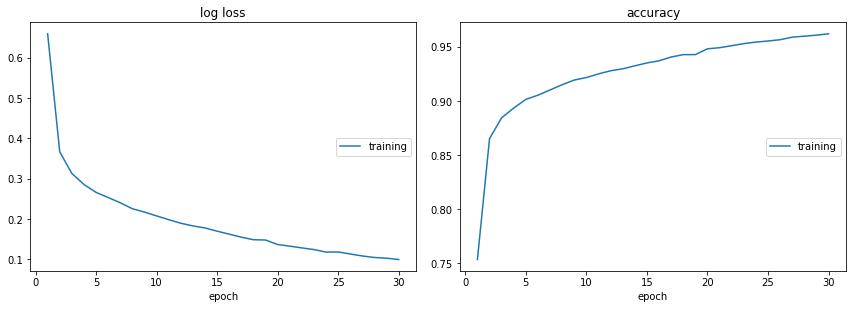

log loss:
training   (min:    0.100, max:    0.659, cur:    0.100)

accuracy:
training   (min:    0.754, max:    0.962, cur:    0.962)
Avg. Test Loss: 0.436  Avg. Test Accuracy: 0.896



In [146]:
fmnist_train = FashionMNIST("./", download=True, train=True, transform=Compose([
    ToTensor(),
    Normalize(mean=[0.1307], std=[0.3081]), 
]))

fmnist_test = FashionMNIST("./", download=True, train=False, transform=Compose([
    ToTensor(),
    Normalize(mean=[0.1307], std=[0.3081]), 
]))

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=False, num_workers=0)

set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'LeNet5_fmnist_classifier_full_training_set_baseline.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

## 2. Train on Small Dataset

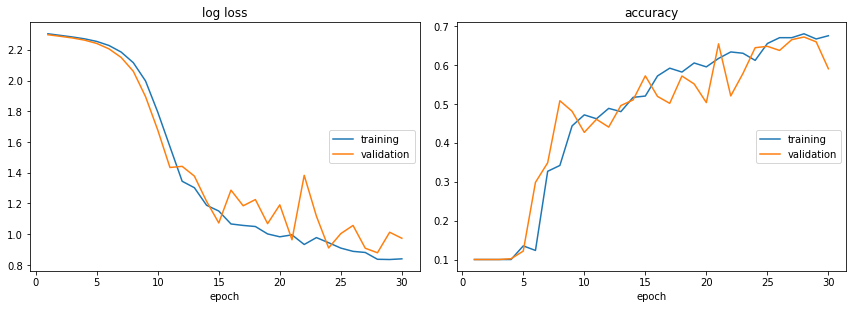

log loss:
training   (min:    0.835, max:    2.304, cur:    0.840)
validation (min:    0.879, max:    2.298, cur:    0.974)

accuracy:
training   (min:    0.100, max:    0.680, cur:    0.675)
validation (min:    0.100, max:    0.672, cur:    0.590)
Avg. Test Loss: 0.989  Avg. Test Accuracy: 0.584



In [152]:
fmnist_train = FashionMNIST("./", download=True, train=True)
fmnist_test = FashionMNIST("./", download=True, train=False)

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.99, random_state=42).split(fmnist_train.train_data, fmnist_train.train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = apply_normalization(fmnist_train.train_data[indices[0]].float()), fmnist_train.train_labels[indices[0]]
X_val, y_val = apply_normalization(fmnist_train.train_data[indices[1]].float()), fmnist_train.train_labels[indices[1]]

fmnist_train = TensorDataset(X_train, y_train.long())
fmnist_validate = TensorDataset(X_val, y_val.long())

def train_model(train_dataset, validation_dataset, momentum=0.5):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model

model = train_model(fmnist_train, fmnist_validate)
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'LeNet5_fmnist_classifier_small_training_set_no_transfer.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

## 3. Transfer Learning from a Network trained on MNIST

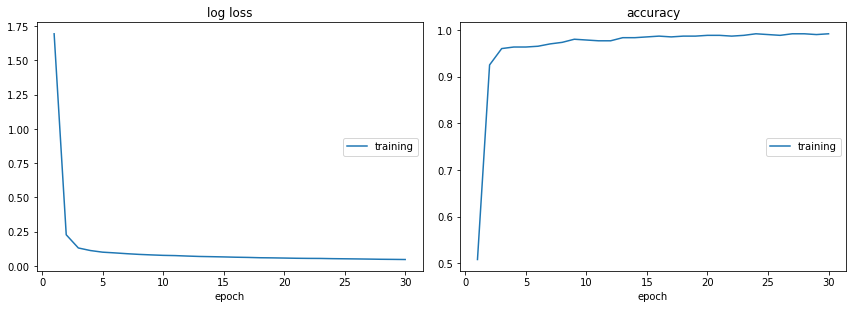

log loss:
training   (min:    0.046, max:    1.694, cur:    0.046)

accuracy:
training   (min:    0.508, max:    0.992, cur:    0.992)
Avg. Test Loss: 0.428  Avg. Test Accuracy: 0.890



In [153]:
set_seed(seed)
model = LeNet5().to(device)
model.load_state_dict(torch.load(F"/content/gdrive/My Drive/models/LeNet5_fmnist_classifier_full_training_set_baseline.pt"))
model.output = nn.Linear(84, 10).to(device)

optimizer = torch.optim.SGD([
                          {'params': model.c1.parameters(), 'lr': 0.0},
                          {'params': model.s2.parameters(), 'lr': 0.0},
                          {'params': model.c3.parameters(), 'lr': 0.0},
                          {'params': model.s4.parameters(), 'lr': 0.0},
                          {'params': model.c5.parameters(), 'lr': 0.0},
                          {'params': model.f6.parameters(), 'lr': 0.0},
                          {'params': model.output.parameters(), 'lr': 1e-2}
                          ], lr=1e-2, momentum=0.9)

criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True, num_workers=0)

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'LeNet5_fmnist_classifier_small_training_set_transfer.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

Almost as good as training from scratch!